In [1]:
import numpy as np
import random
import lib
from scipy.spatial import distance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from class_model import  create_model
from distill_dataset import ClassificationDataset, UNK_WORD, distill_collate_fun, emb_collate_fun
import lib
from train_distill import DistillModule
import distill_emb_model
import torch

import eval_analogy

In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
text = open('data/word-analogy.txt', encoding='utf-8').read().split('\n')
words = []
for line in text:
    if ':' in line:
        continue
    ws =  line.strip().split()
    words.extend(ws)
words = sorted(set(words))

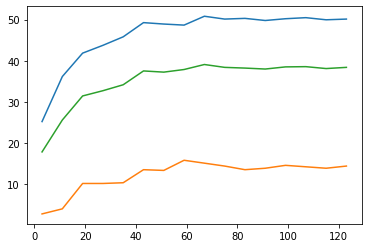

In [21]:
model = distill_emb_model.create_am_distill_emb("data/am-charset.txt", 0.0, model_size="small").eval()
folder = "distill-am-small"
x = []
y = []
for idx in range(3, 128, 8):
    checkpoint = torch.load(f"saves/{folder}/epoch={idx}-val_loss=0.00000-val_f1=0.00000.ckpt")
    state = {k[6:]:v for i, (k, v) in enumerate(checkpoint['state_dict'].items())}
    device = 'cpu'
    model.load_state_dict(state)
    model=model.to(device).eval()

    with torch.no_grad():
        vecs = lib.predict(model, words, "data/am-charset.txt", device=device)

        vecs = vecs.numpy()
        f = open("dataset/corpus/am-distill.vec", encoding='utf-8', mode='w')
        f.write(f"{vecs.shape[0]} {vecs.shape[1]}\n")
        for i in range(len(vecs)):
            word = words[i]
            line = " ".join([str(x) for x in vecs[i]])
            line = word + " " + line + "\n"
            f.write(line)
        f.close()
        
        result = eval_analogy.evaluate("dataset/corpus/am-distill.vec", "data/word-analogy.txt")
        x.append([result['syntactic'], result['semantic'], result['Total accuracy']])
        y.append(idx)

x = np.array(x)
y = np.array(y)

plt.plot(y, x)
plt.show()

In [22]:
print(",".join(str(d) for d in x[:, 1]))

2.816901408450704,4.049295774647887,10.211267605633802,10.211267605633802,10.387323943661972,13.556338028169014,13.380281690140846,15.845070422535212,15.140845070422536,14.43661971830986,13.556338028169014,13.908450704225352,14.612676056338028,14.26056338028169,13.908450704225352,14.43661971830986


In [12]:
xx = [1.58450704,  4.57746479,  6.86619718,  9.68309859, 12.14788732, 10.73943662,
 12.32394366, 14.43661972, 14.26056338, 14.43661972, 14.26056338, 14.43661972,
 14.43661972, 14.61267606, 14.96478873, 15.14084507]

yy = [2.816901408450704,4.049295774647887,10.211267605633802,10.211267605633802,
10.387323943661972,13.556338028169014,13.380281690140846,15.845070422535212,15.140845070422536,
14.43661971830986,13.556338028169014,13.908450704225352,14.612676056338028,14.26056338028169,13.908450704225352,14.43661971830986]

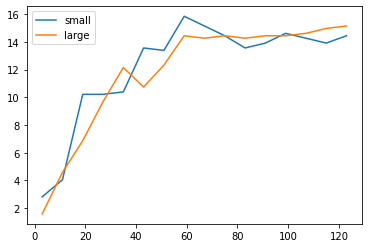

In [20]:
k = np.arange(3, 128, 8)
plt.plot(k, yy, label='small')
plt.plot(k, xx, label='large')
plt.legend()
plt.show()